#Predicting miles per gallon from car data using linear regression 

##Import data and explore

In [50]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt



columns = ["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "model year", "origin", "car name"]
cars = pd.read_table("/Users/matthu24/.spyder2-py3/auto-mpg.data.txt", delim_whitespace=True, names=columns)
print(cars.head(5))


   mpg  cylinders  displacement horsepower  weight  acceleration  model year  \
0   18          8           307      130.0    3504          12.0          70   
1   15          8           350      165.0    3693          11.5          70   
2   18          8           318      150.0    3436          11.0          70   
3   16          8           304      150.0    3433          12.0          70   
4   17          8           302      140.0    3449          10.5          70   

   origin                   car name  
0       1  chevrolet chevelle malibu  
1       1          buick skylark 320  
2       1         plymouth satellite  
3       1              amc rebel sst  
4       1                ford torino  


In [51]:
missing_values = cars.isnull().sum()
print(missing_values)
describe = cars.describe()
print(describe)

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64
              mpg   cylinders  displacement       weight  acceleration  \
count  398.000000  398.000000    398.000000   398.000000    398.000000   
mean    23.514573    5.454774    193.425879  2970.424623     15.568090   
std      7.815984    1.701004    104.269838   846.841774      2.757689   
min      9.000000    3.000000     68.000000  1613.000000      8.000000   
25%     17.500000    4.000000    104.250000  2223.750000     13.825000   
50%     23.000000    4.000000    148.500000  2803.500000     15.500000   
75%     29.000000    8.000000    262.000000  3608.000000     17.175000   
max     46.600000    8.000000    455.000000  5140.000000     24.800000   

       model year      origin  
count  398.000000  398.000000  
mean    76.010050    1.572864  
std      3.697627    0.802055  
min     70.000000    1.000000 

A couple rows have "?" for horsepower values, but we will leave them there because we don't have a lot of data.  Most of the data is complete.

##Feature selection

In [52]:
#see which columns are most correlated with mpg 
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif

predictors = ["cylinders","displacement","weight","model year","origin","acceleration"]
# Perform feature selection
#initialize selector
selector = SelectKBest(f_classif, k=5)
#"train" selector on predictors and see how they each correlate to survived column
selector.fit(cars[predictors], cars["mpg"])

# Get the raw p-values for each feature, and transform from p-values into scores
#corresponding predictor for scores is numbered from 0-9
scores = -np.log10(selector.pvalues_)
scores_df = pd.DataFrame({'Scores':scores},index = predictors)
print(scores_df)



                 Scores
cylinders     63.620117
displacement  66.632707
weight        73.120627
model year    19.103682
origin        15.559768
acceleration   5.549291


Acceleration and origin are the least correlated
Weight,cylinders, and displacement are the most correlated to mpg


##Explore trends

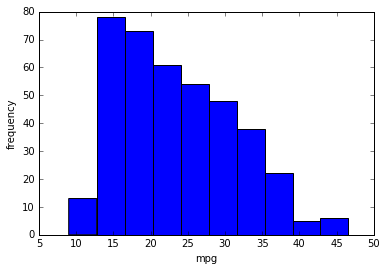

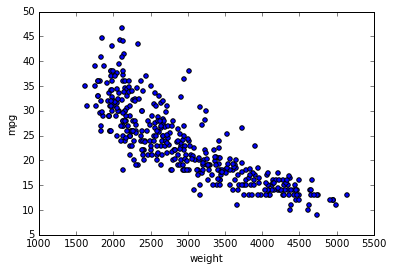

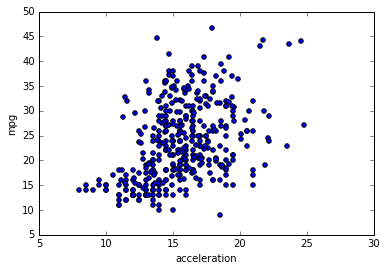

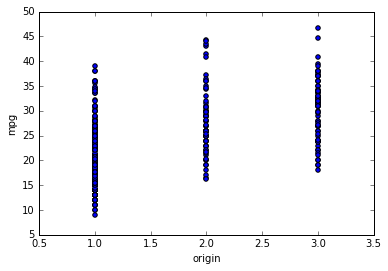

In [53]:
plt.hist(cars["mpg"])
plt.ylabel("frequency")
plt.xlabel("mpg")
plt.show()

#plot most correlated
plt.scatter(cars["weight"],cars["mpg"])
plt.xlabel("weight")
plt.ylabel("mpg")
plt.show()

#plot least correlated
plt.scatter(cars["acceleration"],cars["mpg"])
plt.xlabel("acceleration")
plt.ylabel("mpg")
plt.show()

plt.scatter(cars["origin"],cars["mpg"])
plt.xlabel("origin")
plt.ylabel("mpg")
plt.show()


##Fitting and predicting using linear regression

In [56]:
#perform cross validation splits and train/predict linear regression model

from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold
high_predictors = ["weight","displacement","cylinders","model year","origin"]
alg = LinearRegression()
kf = KFold(cars.shape[0],n_folds = 3,random_state=1)

predictions = []

#kf splits cars DF into three sections,
#we always train two sections, then test the third section

for train,test in kf:
    #For both the predictor columns and the target column, split the data into
    #training sets (meaning we grab 2/3 of the rows for the specified columns)
    train_predictors = cars[high_predictors].iloc[train,:]
    train_target = cars["mpg"].iloc[train]
    
    #train the training data!
    alg.fit(train_predictors,train_target)
    
    #use the fit to predict on the test data
    prediction = alg.predict(cars[high_predictors].iloc[test,:])
    predictions.append(prediction)
    
import numpy as np
#predictions is currently a list of three lists: piece the three lists together 
predictions = np.concatenate(predictions,axis = 0)
print(predictions[0:10])

[ 13.08614458  11.65002098  13.53776446  13.59330204  13.48559232
   6.89440536   6.74143167   7.07149724   6.23919136  10.44652684]


##Model Error

In [59]:
#compute error of model
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(cars["mpg"], predictions)
rmse = mse **0.5
print("mse = {0}".format(mse))
print("rmse = {0}".format(rmse))

mse = 16.63650514270182
rmse = 4.078787214687942


The five chosen predictors (weight, displacement, cylinders, model year, and origin) give the lowest rmse.

##Determine which car brands have the highest mpg

In [60]:
first_names = []

for car in cars["car name"]:
    first_name = car.split()[0]
    first_names.append(first_name)
    
brand_DF = pd.DataFrame({'brands':first_names})
cars["brand"] = brand_DF

brands = brand_DF['brands'].value_counts()
popular_brands = brands.iloc[0:5]
print(popular_brands)

ford         51
chevrolet    43
plymouth     31
amc          28
dodge        28
Name: brands, dtype: int64


In [61]:
def average_mpg(brand):
    filtered_cars = cars[cars["brand"] == brand]
    ave_mpg = filtered_cars["mpg"].mean()
    return ave_mpg
    
brands = pd.DataFrame({'value counts':brands})
brands["mpg"]=brands.index.map(lambda x: average_mpg(x))
brands = brands.sort_values(["mpg"],ascending = False)
print(brands)

               value counts        mpg
vw                        6  39.016667
nissan                    1  36.000000
triumph                   1  35.000000
honda                    13  33.761538
renault                   5  32.880000
datsun                   23  31.113043
mazda                    10  30.860000
subaru                    4  30.525000
vokswagen                 1  29.800000
volkswagen               15  29.106667
fiat                      8  28.912500
toyota                   25  28.372000
audi                      7  26.714286
maxda                     2  26.050000
opel                      4  25.750000
mercedes                  1  25.400000
capri                     1  25.000000
saab                      4  23.900000
bmw                       2  23.750000
peugeot                   8  23.687500
mercedes-benz             2  23.250000
toyouta                   1  23.000000
dodge                    28  22.060714
plymouth                 31  21.703226
volvo                    